text,image,score
普京,,7.275905132293701
普京,,6.634604454040527
普京,,6.608341217041016

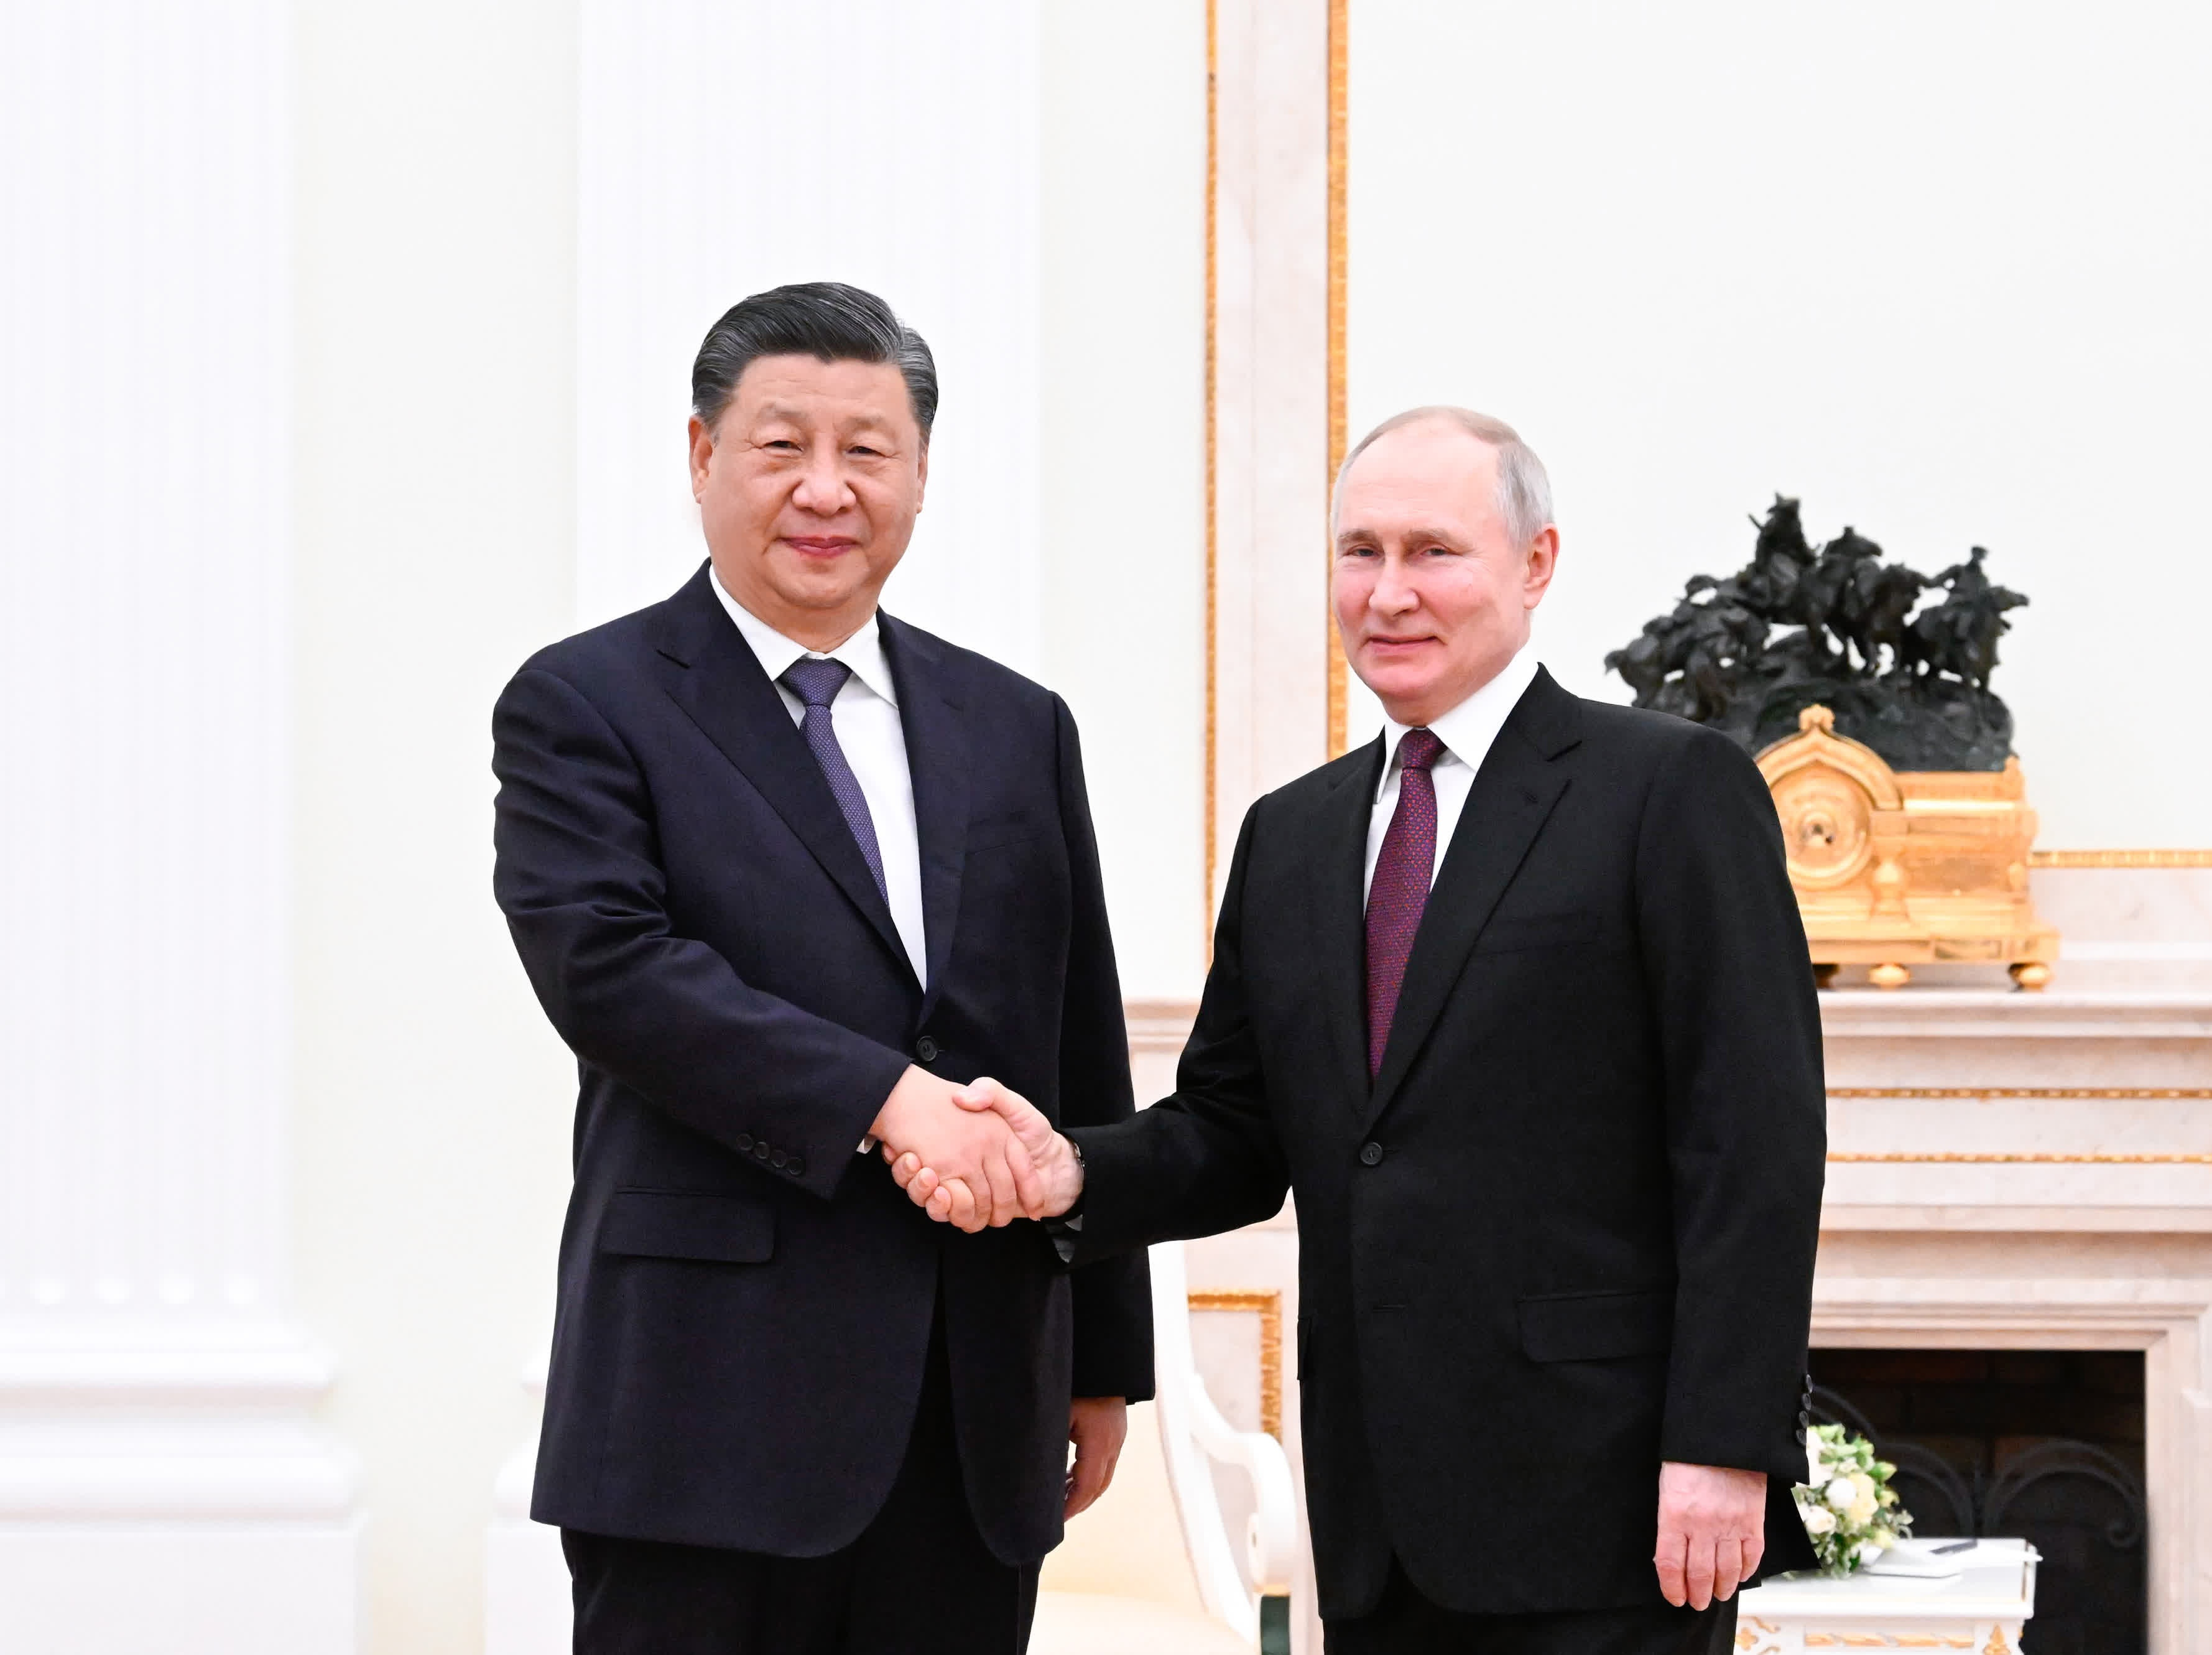
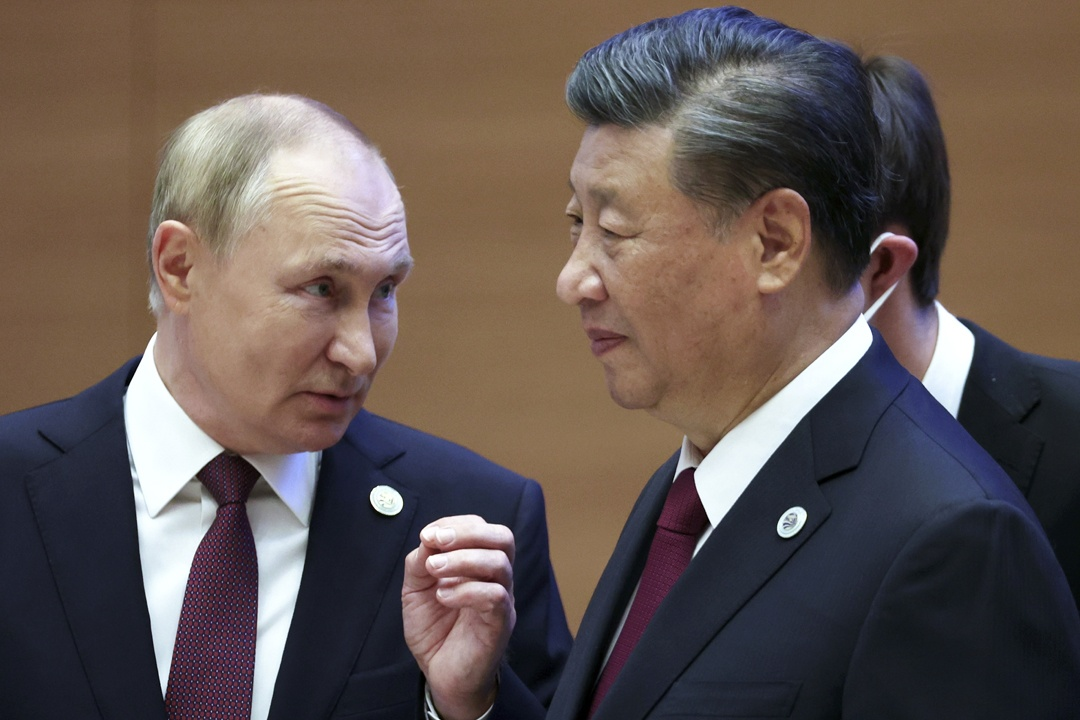
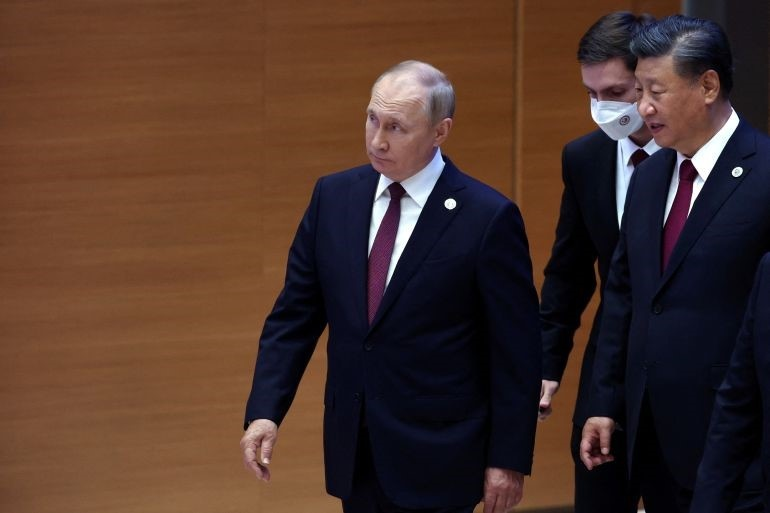

In [21]:
import towhee
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility


HOST = 'localhost'
PORT = '19530'
COLLECTION_NAME = 'text_image_search'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'IP'
DIM = 512
TOPK = 3

#创建集群
def create_milvus(exist_ok=False):
     try:
         connections.connect(host=HOST, port=PORT)
     except Exception:
         print(f'Fail to connect Milvus with {HOST}:{PORT}')

     if utility.has_collection(COLLECTION_NAME):
         collection = Collection(COLLECTION_NAME)
         if exist_ok:
             print(f'Using existed collection: {COLLECTION_NAME}.')
             return collection
         else:
             print('Deleting previous collection...')
             collection.drop()
      
     print('Creating collection...')
     fields = [
         FieldSchema(name='id', dtype=DataType.INT64, description='embedding ids', is_primary=True, auto_id=True),
         FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embeddings', dim=DIM),
         FieldSchema(name='path', dtype=DataType.VARCHAR, description='image path', max_length=500)
         ]
     schema = CollectionSchema(fields=fields, description='text image search')
     collection = Collection(name=COLLECTION_NAME, schema=schema)
     
     print('Creating index...')
     index_params = {
         'metric_type': METRIC_TYPE,
         'index_type': INDEX_TYPE,
         'params': {"nlist": 2048}
     }

     collection.create_index(field_name='embedding', index_params=index_params)  # 创建失败，暂不创建索引

     
     print(f'Milvus collection is ready: {COLLECTION_NAME} ({INDEX_TYPE}, {METRIC_TYPE}).')
     return collection

collection = create_milvus()


# # 插入图片
insert = (
    towhee.glob['path']('E:\python\Google Search/*.jpg') #图片路径
           .image_decode['path', 'image']()
           .image_text_embedding.taiyi['image', 'vec'](
                    model_name='taiyi-clip-roberta-102m-chinese',
                    modality='image')
           .ann_insert.milvus[('vec', 'path'), 'milvus_res'](
                    uri=f'tcp://{HOST}:{PORT}/{COLLECTION_NAME}')
           .select['path', 'image', 'milvus_res']()
           .show()
)

print(f'Total vectors in collection: {collection.num_entities}')


# # 文字搜图
text_query = (
    #修改文字内容
     towhee.dc['text'](['普京'])
           .image_text_embedding.taiyi['text', 'vec'](
                    model_name='taiyi-clip-roberta-102m-chinese',
                    modality='text')
           .ann_search.milvus['vec', 'milvus_res'](
                    uri=f'tcp://{HOST}:{PORT}/{COLLECTION_NAME}',
                    metric_type=METRIC_TYPE,
                    limit=TOPK,
                    output_fields=['path'])
           .flatten('milvus_res')
           .runas_op['milvus_res', ('image_path', 'score')](lambda x: (x.path, x.score))
           .image_decode['image_path', 'image']()
           .select['text', 'image', 'score']()
           .show()
)

